# Explore Data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import time
import warnings
warnings.filterwarnings('ignore')

C:\Users\caleb\Downloads\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
path_to_data = 'data/DataCoSupplyChainDataset.csv'
data = pd.read_csv(path_to_data, encoding='latin-1')

### 1. What is the nature of data available to you?

In [3]:
data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


### 2. What are other (additional) data sources you can access to achieve your objectives?

- We can leverage the geopy Python package for coverting addresses to Latitude Longitude to use as a training feature when trying to predict something about the timeliness of the delivery.

https://pypi.org/project/geopy/

- We can look into literature on how month of year affects deliveries across the world, motivated by how customers care about delivery time.


https://www.marketingcharts.com/industries/retail-and-e-commerce-82710

https://www.hollingsworthllc.com/how-late-deliveries-impact-customer-retention/


### 3. Prepare the data for AutoML (DataRobot)

We want to predict:

- Days for shipment (actual)
- Classification of being early, on-time, or late order

TODO:

1. Convert Customer Country, State, City, Zipcode, Street to longitude-latitude with geopy
2. Create a feature calculating euclidean distance between customer and store given the longitude-latitude pairs
3. Convert shipping date to categorical data by month (one-hot encoding)
4. Convert shipping mode to categorical data (one-hot encoding)
5. Convert delivery status to categorical data (one-hot encoding)
6. Create a feature representing the recent customer demand for a given product on a per store basis
7. Create a feature representing % above average for recent customer demand on the product on a per store basis
8. Create a feature representing the category of order Delivery Status change

In [59]:
relevant_columns = [
    'Customer Id',
    'Days for shipping (real)',
    'Days for shipment (scheduled)',
    'Delivery Status',
    'Late_delivery_risk',
    'Customer City',
    'Customer Country',
    'Customer State',
    'Customer Street',
    'Customer Zipcode',
    'Latitude',
    'Longitude',
    'order date (DateOrders)',
    'shipping date (DateOrders)',
    'Shipping Mode',
    'Product Name',
]
X_df = data[relevant_columns]
X_desc = pd.DataFrame(index = X_df.columns, columns = ['Type', 'Description', 'Purpose'])
X_df.head()

,Customer Id,Days for shipping (real),Days for shipment (scheduled),Delivery Status,Late_delivery_risk,Customer City,Customer Country,Customer State,Customer Street,Customer Zipcode,Latitude,Longitude,order date (DateOrders),shipping date (DateOrders),Shipping Mode,Product Name
0,20755,3,4,Advance shipping,0,Caguas,Puerto Rico,PR,5365 Noble Nectar Island,725.0,18.251453,-66.037056,1/31/2018 22:56,2/3/2018 22:56,Standard Class,Smart watch
1,19492,5,4,Late delivery,1,Caguas,Puerto Rico,PR,2679 Rustic Loop,725.0,18.279451,-66.037064,1/13/2018 12:27,1/18/2018 12:27,Standard Class,Smart watch
2,19491,4,4,Shipping on time,0,San Jose,EE. UU.,CA,8510 Round Bear Gate,95125.0,37.292233,-121.881279,1/13/2018 12:06,1/17/2018 12:06,Standard Class,Smart watch
3,19490,3,4,Advance shipping,0,Los Angeles,EE. UU.,CA,3200 Amber Bend,90027.0,34.125946,-118.291016,1/13/2018 11:45,1/16/2018 11:45,Standard Class,Smart watch
4,19489,2,4,Advance shipping,0,Caguas,Puerto Rico,PR,8671 Iron Anchor Corners,725.0,18.253769,-66.037048,1/13/2018 11:24,1/15/2018 11:24,Standard Class,Smart watch


In [61]:
pd.set_option('display.max_colwidth', -1)
X_desc.loc['Customer Id', :] = ['Categorical Integer', 'ID of customer', 'to evaluate customer related trends']
X_desc.loc['Days for shipping (real)', :] = ['Integer', 'actual number of days to ship order', 'to compare against expected delivery time']
X_desc.loc['Days for shipment (scheduled)', :] = ['Integer', 'expected number of days to ship order', 'to compare against actual delivery time']
X_desc.loc['Delivery Status', :] = ['Categorical String', 'Categories: Advance shipping, Late delivery, Shipping on time, Shipping canceled', 'to better specify order statuses, rather than late or on-time']
X_desc.loc['Late_delivery_risk', :] = ['Categorical Integer', '1 is late, 0 is on-time', 'to identify orders flagged as risk for late delivery by company']
X_desc.loc['Customer City', :] = ['Sting', 'city of residence of customer', 'to determine geospatial coordinates of customer']
X_desc.loc['Customer Country', :] = ['Sting', 'country of residence of customer', 'to determine geospatial coordinates of customer']
X_desc.loc['Customer State', :] = ['Sting', 'state of residence of customer', 'to determine geospatial coordinates of customer']
X_desc.loc['Customer Street', :] = ['Sting', 'street of residence of customer', 'to determine geospatial coordinates of customer']
X_desc.loc['Customer Zipcode', :] = ['Integer', 'zipcode of residence of customer', 'to determine geospatial coordinates of customer']
X_desc.loc['Latitude', :] = ['Float', 'latitude of store ordered from', 'to calculate distance of store from customer']
X_desc.loc['Longitude', :] = ['Float', 'longitude of store ordered from', 'to calculate distance of store from customer']
X_desc.loc['order date (DateOrders)', :] = ['DateTime', 'date order was placed', 'to determine temporal dependencies between time of year and late orders']
X_desc.loc['shipping date (DateOrders)', :] = ['DateTime', 'date order shipped', 'to determine temporal dependencies between time of year and late orders']
X_desc.loc['Shipping Mode', :] = ['Categorical String', 'Categories: Standard Class, First Class, Second Class, Same Day', 'to support in predicting order delivery time']
X_desc.loc['Product Name', :] = ['Categorical String', 'name of ordered product', 'to support in calculating product demand']
X_desc

,Type,Description,Purpose
Customer Id,Categorical Integer,ID of customer,to evaluate customer related trends
Days for shipping (real),Integer,actual number of days to ship order,to compare against expected delivery time
Days for shipment (scheduled),Integer,expected number of days to ship order,to compare against actual delivery time
Delivery Status,Categorical String,"Categories: Advance shipping, Late delivery, Shipping on time, Shipping canceled","to better specify order statuses, rather than late or on-time"
Late_delivery_risk,Categorical Integer,"1 is late, 0 is on-time",to identify orders flagged as risk for late delivery by company
Customer City,Sting,city of residence of customer,to determine geospatial coordinates of customer
Customer Country,Sting,country of residence of customer,to determine geospatial coordinates of customer
Customer State,Sting,state of residence of customer,to determine geospatial coordinates of customer
Customer Street,Sting,street of residence of customer,to determine geospatial coordinates of customer
Customer Zipcode,Integer,zipcode of residence of customer,to determine geospatial coordinates of customer


### 4. Conduct exploratory data analysis

TODO:
- Look at these features on a per store basis
- Look at duplicate order ID's and their respective Delivery Status changes (not applicable now)
- Look into the relationship between the shipping mode and the order being late
- Look into how we should weight how late the order is
- Look into the relationship between the order being late and the order being cancelled

C:\Users\caleb\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\caleb\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Mean orders per customer 8.740993608367228
Median orders per customer 7.0
Proportion of customers that are repeat customers 0.591564981599845
Mean orders per repeat customer 14.085618400589343
Median orders per repeat customer 13.0


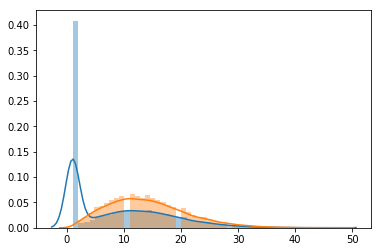

In [48]:
customer_id = X_df['Customer Id']
customer_value_counts = customer_id.value_counts()
customer_freq = customer_value_counts.values
sns.distplot(customer_freq)

repeat_customers = customer_freq[customer_freq > 1]
sns.distplot(repeat_customers)

print("Mean orders per customer " + str(np.mean(customer_freq)))
print("Median orders per customer " + str(np.median(customer_freq)))

print("Proportion of customers that are repeat customers " + str(len(repeat_customers)/len(customer_freq)))

print("Mean orders per repeat customer " + str(np.mean(repeat_customers)))
print("Median orders per repeat customer " + str(np.median(repeat_customers)))

C:\Users\caleb\Downloads\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\caleb\Downloads\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\caleb\Downloads\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

Delivery Days (scheduled) Value Counts:
 4    107752
2    35216 
1    27814 
0    9737  
Name: Days for shipment (scheduled), dtype: int64 

Delivery Days (real) Value Counts:
 2    56618
3    28765
6    28723
4    28513
5    28163
0    5080 
1    4657 
Name: Days for shipping (real), dtype: int64 

Delivery Days Difference Distribution (negative is late):
 -1    33.595910
 0    18.697755
-2    15.908575
 1    12.020895
 2    12.002061
-3    3.906514 
-4    3.868291 
dtype: float64 

Late Deliveries percentage 57.279289160697765
Delivery Days ME (only late is considered an error): 0.9260576449016447
Delivery Days MSE (only late is considered an error): 1.9428148837518489


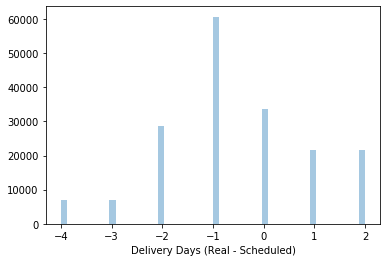

In [20]:
delivery_days_sched = X_df['Days for shipment (scheduled)']
delivery_days_real = X_df['Days for shipping (real)']

delivery_days_diff = delivery_days_sched - delivery_days_real
X_df['Days Late'] = delivery_days_diff
X_df['Days Late'][X_df['Days Late'] > 0] = 0
X_df['Days Late'] = X_df['Days Late'].abs()

delivery_days_late = delivery_days_diff[delivery_days_diff < 0].abs()

delivery_days_late_ME = delivery_days_late.sum() / delivery_days_diff.size

delivery_days_MSE = (delivery_days_late ** 2).sum() / delivery_days_diff.size

delivery_days_dist = delivery_days_diff.value_counts(normalize=True) * 100

late_delivery_percentage = (delivery_days_late.size / delivery_days_diff.size) * 100

delivery_days_series = pd.Series(delivery_days_diff, name="Delivery Days (Real - Scheduled)")
sns.distplot(delivery_days_series, kde=False)

print("Delivery Days (scheduled) Value Counts:\n", delivery_days_sched.value_counts(), "\n")
print("Delivery Days (real) Value Counts:\n", delivery_days_real.value_counts(), "\n")
print("Delivery Days Difference Distribution (negative is late):\n", delivery_days_dist, "\n")
print("Late Deliveries percentage", late_delivery_percentage)
print("Delivery Days ME (only late is considered an error):", delivery_days_late_ME)
print("Delivery Days MSE (only late is considered an error):", delivery_days_MSE)

In [51]:
late_delivery_risk = X_df['Late_delivery_risk']
# 1 is late, 0 is not late
print("Late Delivery Risk Value Counts\n", late_delivery_risk.value_counts())

Late Delivery Risk Value Counts
 1    98977
0    81542
Name: Late_delivery_risk, dtype: int64


In [50]:
delivery_status = X_df['Delivery Status']
print("Delivery Status Value Counts\n", delivery_status.value_counts())

Delivery Status Value Counts
 Late delivery        98977
Advance shipping     41592
Shipping on time     32196
Shipping canceled    7754 
Name: Delivery Status, dtype: int64


In [25]:
delivery_mode = X_df['Shipping Mode']
delivery_status = X_df['Delivery Status']
standard = X_df[X_df['Shipping Mode'] == 'Standard Class']
second = X_df[X_df['Shipping Mode'] == 'Second Class']
first = X_df[X_df['Shipping Mode'] == 'First Class']
same = X_df[X_df['Shipping Mode'] == 'Same Day']

print("Standard Class:\n", standard['Delivery Status'].value_counts(normalize=True) * 100, "\n")
print("Second Class:\n", second['Delivery Status'].value_counts(normalize=True) * 100, "\n")
print("First Class:\n", first['Delivery Status'].value_counts(normalize=True) * 100, "\n")
print("Same Day:\n", same['Delivery Status'].value_counts(normalize=True) * 100, "\n")

print("Delivery Mode Value Counts\n", delivery_mode.value_counts())

Standard Class:
 Advance shipping     38.599748
Late delivery        38.071683
Shipping on time     19.060435
Shipping canceled    4.268134 
Name: Delivery Status, dtype: float64 

Second Class:
 Late delivery        76.632781
Shipping on time     19.363358
Shipping canceled    4.003862 
Name: Delivery Status, dtype: float64 

First Class:
 Late delivery        95.322499
Shipping canceled    4.677501 
Name: Delivery Status, dtype: float64 

Same Day:
 Shipping on time     49.697032
Late delivery        45.743042
Shipping canceled    4.559926 
Name: Delivery Status, dtype: float64 

Delivery Mode Value Counts
 Standard Class    107752
Second Class      35216 
First Class       27814 
Same Day          9737  
Name: Shipping Mode, dtype: int64


In [29]:
delivery_mode_status = pd.DataFrame(index = delivery_mode.unique(), columns = delivery_status.unique())
delivery_mode_status.loc['Standard Class', :] = [38.599748, 38.071683, 19.060435, 4.268134]
delivery_mode_status.loc['Second Class', :] = [0.0, 76.632781, 19.363358, 4.268134]
delivery_mode_status.loc['First Class', :] = [0.0, 95.322499, 0.0, 4.677501]
delivery_mode_status.loc['Same Day', :] = [0.0, 45.743042, 49.697032, 4.559926]
delivery_mode_status

,Advance shipping,Late delivery,Shipping on time,Shipping canceled
Standard Class,38.5997,38.0717,19.0604,4.26813
First Class,0,95.3225,0,4.6775
Second Class,0,76.6328,19.3634,4.26813
Same Day,0,45.743,49.697,4.55993


In [80]:
X_df['Late Delivery'] = X_df['Days Late'] > 0
late_orders = X_df.loc[X_df['Late Delivery'], :]
ontime_orders = X_df.loc[~X_df['Late Delivery'], :]

print(late_orders['Delivery Status'].value_counts(normalize=True) * 100, "\n")
print(ontime_orders['Delivery Status'].value_counts(normalize=True) * 100)

Late delivery        95.722437
Shipping canceled    4.277563 
Name: Delivery Status, dtype: float64 

Advance shipping     53.932235
Shipping on time     41.748467
Shipping canceled    4.319299 
Name: Delivery Status, dtype: float64


C:\Users\caleb\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### 5. Address target leakage

# Conduct Feature Engineering

Explain in detail what you have done both in DataRobot and prior to moving the data to DataRobot

In [63]:
X_df['Customer Address'] = X_df['Customer City'] + ", " + X_df["Customer State"]

In [ ]:
geolocator = Nominatim(user_agent="Project1")
addresses = X_df['Customer Address'].unique()
location_dict = {}
invalid_addresses = ['Philadelphia, PA', 'Vega Baja, PR', 'Caguas, PR']
for address in addresses:
    if address in invalid_addresses: 
        continue
    try:
        location = geolocator.geocode(address)
        if not location:
            continue
    except:
        continue
    latitude = location.latitude
    longitude = location.longitude
    location_dict[address] = [latitude, longitude]

In [64]:
location_keys = location_dict.keys()
def address_lookup(add):
    if add in location_keys:
        lat, lon = location_dict[add]
    else:
        lat = 0
        lon = 0
    return lat, lon

X_df['Customer Latitude'] = 0.0
X_df['Customer Longitude'] = 0.0

lat_lon_pairs = X_df['Customer Address'].apply(address_lookup)

In [65]:
X_df['Customer Latitude'] = [i[0] for i in lat_lon_pairs]
X_df['Customer Longitude'] = [i[1] for i in lat_lon_pairs]
X_df = X_df[X_df['Customer Latitude'] != 0]

In [66]:
def calc_distance(c_lat, c_lon, lat, lon):
    return geodesic((c_lat, c_lon), (lat, lon))

X_df['Order Distance'] = X_df.apply(lambda row: calc_distance(row['Customer Latitude'], row['Customer Longitude'], row['Latitude'], row['Longitude']), axis=1)

In [67]:
X_df['Order Month'] = pd.DatetimeIndex(X_df['order date (DateOrders)']).month
X_df['Order Year'] = pd.DatetimeIndex(X_df['order date (DateOrders)']).year

In [68]:
demand_lookup = X_df.groupby(['Order Year', 'Order Month', 'Product Name']).size().to_dict()
def product_demand_lookup(year, month, name):
    return demand_lookup[(year, month, name)]

X_df['Recent Product Demand'] = X_df.apply(lambda row: product_demand_lookup(row['Order Year'], row['Order Month'], row['Product Name']), axis=1)

In [69]:
num_months = X_df.groupby(['Order Year', 'Order Month']).ngroups
volume_lookup = (X_df.groupby('Product Name').size() / num_months).to_dict()

def average_volume_lookup(name):
    return volume_lookup[name]

X_df['Average Product Demand'] = X_df['Product Name'].apply(average_volume_lookup)

In [70]:
intermediate_columns = [
    'Customer Id', 'Days for shipping (real)',
    'Days for shipment (scheduled)', 'Delivery Status',
    'Late_delivery_risk', 'order date (DateOrders)',
    'Shipping Mode', 'Product Name',
    'Order Month', 'Order Year',
    'Recent Product Demand', 'Average Product Demand',
    'Order Distance'
]
binary_classifier_columns = [
    'Late_delivery_risk', 'order date (DateOrders)',
    'Shipping Mode', 'Product Name',
    'Order Month', 'Order Year',
    'Recent Product Demand', 'Average Product Demand',
    'Order Distance'
]
X_intermediate = X_df[intermediate_columns]
X_bc = X_df[binary_classifier_columns]

In [71]:
X_final.to_csv('data/intermediate_features.csv', index=False)
X_bc.to_csv('data/binary_classifier_features.csv', index=False)

In [72]:
final_features = [
    'Days for Shipping (Real)',
    'Late Delivery Risk',
    'Order Distance',
    'Order Date',
    'Shipping Mode',
    'Product Name',
    'Recent Product Demand',
    'Average Product Demand'
]
X_final = pd.DataFrame(index = final_features, columns = ['Type', 'Description', 'Feature Type'])
X_final.loc['Days for Shipping (Real)', :] = ['Integer', 'actual number of days to ship order', 'target variable']
X_final.loc['Late Delivery Risk', :] = ['Categorical Integer', '0: no risk, 1: risk', 'target variable']
X_final.loc['Order Distance', :] = ['Float', 'geodesic distance between customer and store', 'training feature']
X_final.loc['Order Date', :] = ['DateTime', 'date and time that order was placed', 'training feature']
X_final.loc['Shipping Mode', :] = ['Cateogorical String', 'Categories: Advance shipping, Late delivery, Shipping on time, Shipping canceled', 'training feature']
X_final.loc['Product Name', :] = ['Cateogorical String', 'name of ordered product', 'training feature']
X_final.loc['Recent Product Demand', :] = ['Integer', 'current monthly volume of product ordered', 'training feature']
X_final.loc['Average Product Demand', :] = ['Float', 'mean monthly volume of product ordered', 'training feature']
X_final

,Type,Description,Feature Type
Days for Shipping (Real),Integer,actual number of days to ship order,target variable
Late Delivery Risk,Categorical Integer,"0: no risk, 1: risk",target variable
Order Distance,Float,geodesic distance between customer and store,training feature
Order Date,DateTime,date and time that order was placed,training feature
Shipping Mode,Cateogorical String,"Categories: Advance shipping, Late delivery, Shipping on time, Shipping canceled",training feature
Product Name,Cateogorical String,name of ordered product,training feature
Recent Product Demand,Integer,current monthly volume of product ordered,training feature
Average Product Demand,Float,mean monthly volume of product ordered,training feature
